In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from astropy.io import fits
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.model_mlp_common import MlpCommonNet
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer
from inverse_problem.nn_inversion import mlp_transform_rescale
from tqdm import tqdm

## Датасет

Данные и немножко визаулизации

In [3]:
filename = '../data/parameters_base.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

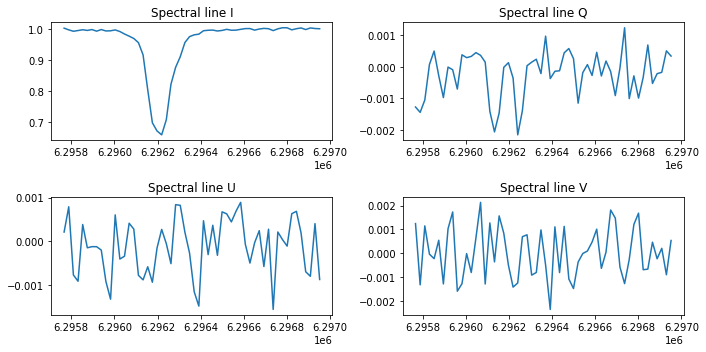

In [4]:
line_type = ['I','Q','U','V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(line_arg, sample['X'][0][:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight = True)

### Загрузка лоадера
Показаны два варианта: под вход полносвязной сети и под сверточный блок. Здесь же стоит определиться со всеми преобразованиями данных

In [5]:
MLP  = True
factors, cont = [1,1000,1000,1000], 40000
angle_transformation, logB = True, True



if MLP:
    transform_name = "mlp_transform_rescale"
    batch_size = 20
    train_loader, val_loader = make_loader(filename=filename, transform_name=transform_name, 
                                           factors = factors, cont_scale = cont, 
                                           logB = logB, angle_transformation = angle_transformation, 
                                           batch_size=128)
    sample_batch = next(iter(train_loader))
    print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
else:
    transform_name = "conv1d_transform_rescale"
    batch_size = 128
    train_loader, val_loader = make_loader(filename=filename, transform_name=transform_name, 
                                           factors = factors, cont_scale = cont, 
                                           logB = logB, angle_transformation = angle_transformation, 
                                           batch_size=128)
    sample_batch = next(iter(train_loader))
    print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
    

torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])


можно загружать лоадер из массива, сейчас сделано так, чтобы на небольшом кусочке учить и быстро проиграть тетрадку

In [6]:
param_array = fits.open(filename)[0].data[:500000]
transform_name = "mlp_transform_rescale"
train_loader, val_loader = make_loader(data_arr=param_array, transform_name=transform_name, 
                                       factors = factors, cont_scale= cont,
                                       angle_transformation = angle_transformation, logB = logB, 
                                       batch_size=128)
sample_batch = next(iter(train_loader))
print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
print(f"Number of batches for train: {len(train_loader)}, for validation: {len(val_loader)}")

torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])
Number of batches for train: 3516, for validation: 391


## Загрузка (определение) модели

In [7]:
model = MlpCommonNet(input_dim=224, output_dim=11, hidden_dims=[200, 200, 100],
                           activation='elu', batch_norm=True, dropout=0.05, number_readout_layers=2);

In [8]:
print(model)

MlpCommonNet(
  (mlp): MLPBlock(
    (FC_layers): ModuleList(
      (0): MLPlayer(
        (linear): Linear(in_features=224, out_features=200, bias=True)
        (batch_normx): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (1): MLPlayer(
        (linear): Linear(in_features=200, out_features=200, bias=True)
        (batch_normx): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (2): MLPlayer(
        (linear): Linear(in_features=200, out_features=100, bias=True)
        (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
    )
  )
  (readout): MLPReadout(
    (FC_layers): ModuleList(
      (0): MLPlayer(
        (linear): Linear(in_features=101, out_features=50, bias=True)
        (batch_normx)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
model.to(device);

In [10]:
def fit_step(dataloader, max_steps = None):
    """ шаг обучения
        max_steps(int): параметр добавлен для тестовых запусках, весь датасет несколько миллионов спектров, 
        мы тут рукотворно режем число батчей 
    """
    train_loss = 0.0
    train_it = 0    
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps,len(dataloader))
    with tqdm(desc="batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i==total:
                break
            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)
               
            outputs = model(x)
            
            optimizer.zero_grad()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_it += 1
            if train_it % 10 == 0:
                pbar_outer.update(10)
        return train_loss / train_it
def eval_step(dataloader):
    model.eval()
    val_loss = 0.0
    val_it = 0
    for i, inputs in enumerate(dataloader):
        x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
        y = inputs['Y'].to(device)
        with torch.no_grad():
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_it += 1
    return val_loss / val_it    

In [11]:
%%time
#!!! Когда будете уже учить по настоящему ставьте None
max_steps = 500 #None
best_valid_loss = float('inf')
history = []
log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
n_epochs = 2
with tqdm(desc="epoch", total = n_epochs, position=0, leave=True) as pbar_outer:
    for epoch in range(n_epochs):
        train_loss = fit_step(train_loader, max_steps = max_steps)
        val_loss = eval_step(val_loader)
        history.append((train_loss, val_loss))
        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,
                                               v_loss=val_loss))
        

epoch:  50%|███████████████████                   | 1/2 [01:29<01:29, 89.33s/it]


Epoch 001 train_loss: 0.6558 val_loss 0.2461


epoch: 100%|██████████████████████████████████████| 2/2 [02:49<00:00, 84.59s/it]


Epoch 002 train_loss: 0.0130 val_loss 0.0098
CPU times: user 2min 47s, sys: 6.14 s, total: 2min 53s
Wall time: 2min 49s


## Анализ модели
Здесь у нас есть две варианта: смотрим как сеть научилась понимать симуляции и как мы переносим модель на реальную жизнь. Для честной оценки архитектуры нам понадобятся симуляции, а в бою - реальные спектры. На Hinode есть и то (реферер) и другое (https://csac.hao.ucar.edu/fg_download.php) (реальный спектры): восстановленные параметры и реальные спектры для них. Они отличаются от того, что мы использовали, но мы про это пока не будем думать

### Реферер 
Посмотрим что он из себя представляет (на самом деле база с параметрами и есть композиция нескольких рефереров)

Несколько примеров лежат подготовленные на гугл диске:
https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [12]:
path_to_refer = '../data/hinode_source/20140926_170005.fits'
#можно с помощью функции сразу нормировать выходы так как это делается для сети, но посмотреть мы можем и сырые данные
data, names = open_param_file(path_to_refer, normalize=True, angle_transformation = angle_transformation, logB = logB)
print(data.shape)


Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift
(512, 873, 11)


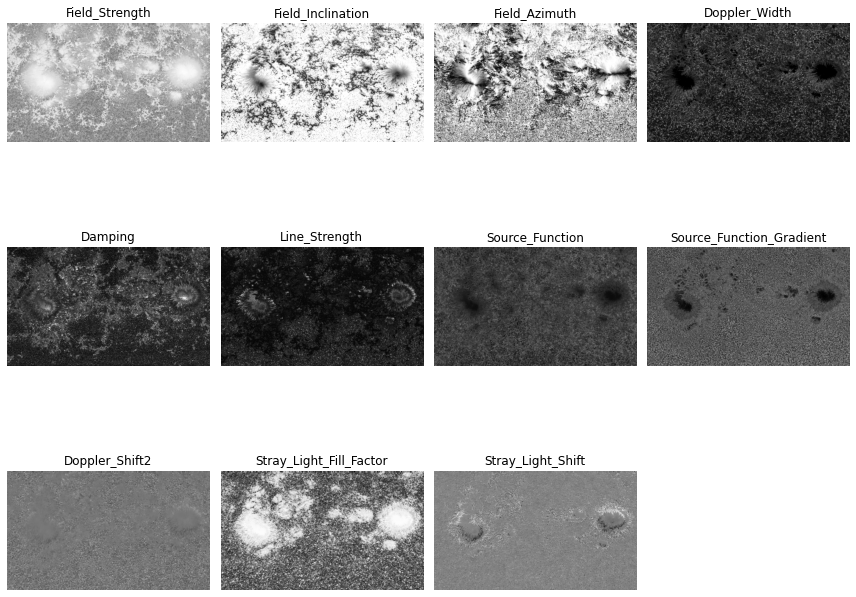

In [13]:
plot_params(data, names=names)

### Тестируем модель на симуляции данных из реферера

тут нам препроцессинг может упростить PregenDataset, можно и руками с помощью  BatchMe приготовить данные (он там и есть). Дальше надо загрузить 500k параметров и сделать симуляцию, поэтому работает это долго (в SpectrumDataset генерация во время обучения, поэтому надо только считать параметры и это быстро)



In [14]:
%%time
transform = mlp_transform_rescale(factors = factors, angle_transformation=angle_transformation, 
                                  cont_scale=cont, logB = logB)
test_dataset = PregenSpectrumDataset(param_path=path_to_refer, source='refer', transform=transform)


CPU times: user 54.7 s, sys: 20 s, total: 1min 14s
Wall time: 1min 17s


In [15]:
%%time
inputs = test_dataset.samples
x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)
model.eval()
with torch.no_grad():
    predicted = model(x)

CPU times: user 2.73 s, sys: 1.95 s, total: 4.68 s
Wall time: 1.83 s


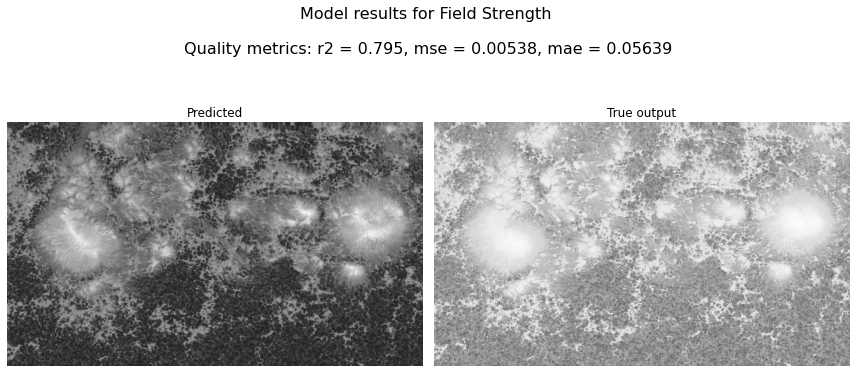

In [16]:
plot_pred_vs_refer(predicted, data, output_index=0)

In [17]:
compute_metrics(data, predicted)

,r2,mse,mae
Field Strength,0.795,0.005,0.056
Field Inclination,0.781,0.015,0.074
Field Azimuth,0.717,0.027,0.104
Doppler Width,0.343,0.017,0.105
Damping,0.429,0.022,0.113
Line Strength,0.275,0.050,0.187
S_0,0.104,0.144,0.368
S_1,0.299,0.032,0.161
Doppler Shift,0.410,0.002,0.032
Filling Factor,0.472,0.047,0.178
